# Лабораторная работа №1 часть 2

## Задание
----
В этом задании вы преобразуете своё решение наименьших квадратов в рекурсивное! Напомним, что у вас есть следующие данные:

| Ток (A) | Напряжение (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

На этот раз вы будете подгонять линейную модель, которая включает в себя смещение: $y = Rx + b$. Если имеет место закон Ома($V = RI$), мы ожидаем, что это смещение будет около нуля.

Вы будете устанавливать начальные параметры с предположением, что ваша предварительная оценка сопротивления $R = 4$, и это довольно грубая оценка. Кроме того, поскольку мы достаточно уверены, что закон Ома справедлив ($V = RI$), с уверенностью можно предположить, что смещение $b$ будет близко к 0. Инициализируйте оценку следующим образом:

$$\hat{R} \sim \mathcal{N}(4, 10.0), \hat{b} \sim \mathcal{N}(0, 0.2)$$

Можно предположить, что мы отлично знаем ток и измерения напряжения искажены аддитивным, независимым и одинаково распределенным гауссовским шумом с дисперсией $0.0225 ~ V^2$.

----
Загружаем измерения тока и напряжения в отдельные массивы и выводим значения на графике:

In [51]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

I = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
V = np.array([1.23, 1.38, 2.06, 2.47, 3.17])

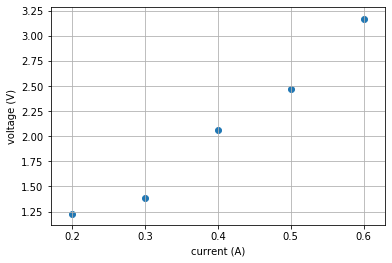

In [52]:
plt.scatter(I, V)

plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)
plt.show()

### Оценка параметра методом пакетного МНК
Перед реализацией рекурсивного МНК рассмотрим оценку параметров, заданную методом пакетного МНК (когда все данные уже имеются). В отличии от предыдущего раза, на этот раз подберём модель, которая содержит смещение: $y = Rx + b$. Этот результат можно использовать позже для сравнения.

Оцениваем сопротивление: $x_{ls} = (H^{T}H)^{-1}H^{T}y$

Параметры линии соответствуют ([R, b]):
[4.97  0.074]


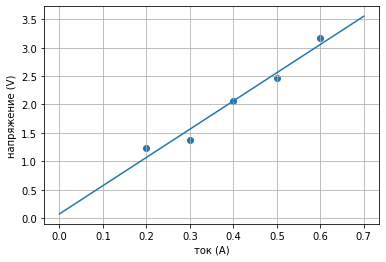

In [54]:
# H - матрица 5x2, потому что доверяем измерениям тока (первый столбец); второй столбец, как обычно.
H = np.ones((5,2))
H[:, 0] = I

# I учтено в H, оцениваем сопротивление -> y = V
x_ls = inv(H.T.dot(H)).dot(H.T.dot(V))

# получили значения R и b с минимальной ошибкой, к которым должна стремиться рекурсивная оценка
print('Параметры линии соответствуют ([R, b]):')
print(x_ls)

# Plot
I_line = np.arange(0, 0.8, 0.1)
V_line = x_ls[0]*I_line + x_ls[1]

plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('ток (A)')
plt.ylabel('напряжение (V)')
plt.grid(True)
plt.show()

### Рекурсивная оценка параметра
Теперь попробуйте рекурсивно реализовать метод наименьших квадратов: 

**Инициализируйте параметр и оценки ковариации**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right] \,\,\, , \,\,\, \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

**Для каждого измерения k**:

----
  * Рассчитать поправочный коэффициент усиления $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Обновить оценку параметра $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Обновить оценку ковариации $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$

## Решение

In [55]:
# ковариационная матрица 2x2 для P_0 (дана в условии задачи);
# на главной диагонали содержит дисперсии R и b (этим обусловлена размерность).
P_k = np.diag([10.0, 0.2])

# x_0 также дан в условии (мат. ожидания R и b)
x_k = np.mat([4, 0])

# отклонение измерения (шум, sigma) 
R_k = 0.0225 

# исторические данные
num_meas = I.shape[0]
x_hist = np.zeros((num_meas + 1,2))
P_hist = np.zeros((num_meas + 1,2,2))

# запишем первичные значения
x_hist[0] = x_k
P_hist[0] = P_k

# единичная матрица для дальнейших вычислений
I_mtx = np.eye(2)

In [56]:
# для каждого измерения...
for k in range(num_meas):
    
    # строим матрицу 1x1, где в первом столбце I, во втором - 1
    # то есть, итеративно перебираем I-измерения
    H_k = np.mat([I[k],1])

    # рассчитываем поправочный коэффициент
    K_k = P_k.dot(H_k.T).dot(inv(H_k.dot(P_k).dot(H_k.T) + R_k))

    # обновляем оценку
    # двойное транспонирование:
    # первый раз, чтобы умножить H_k на x_k;
    # второй раз обратно, чтобы сложить и записать в историю
    x_k = x_k + (K_k.dot(V[k] - H_k.dot(x_k.T))).T

    # обновляем ковариации
    P_k = (I_mtx - K_k.dot(H_k)).dot(P_k)

    # обновляем историю
    P_hist[k+1] = P_k
    x_hist[k+1] = x_k
    
print('Лучшая оценка параметра:')
print(x_k)

Лучшая оценка параметра:
[[4.97896278 0.06886542]]


## Отрисовка результатов
----
Отобразим результаты решения на каждом шагу. На графике видно, что значение сходится к пакетному решению наименьших квадратов из предыдущего блока.

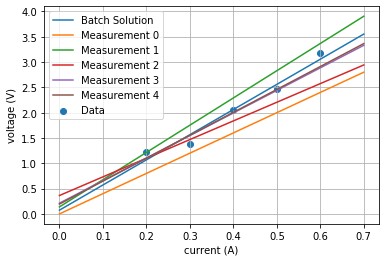

In [57]:
#Plot
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1)
for k in range(num_meas):
    V_line = x_hist[k,0]*I_line + x_hist[k,1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

## Вывод
----
В рамках лабораторной работы №1 была произведена оценка сопротивления в соответствии с заданием с помощью метода наименьших квадратов. Данная оценка впоследствии была использована в качестве истинного значения для сравнения с результатом реализации рекурсивного метода наименьших квадратов. На представленных в работе графиках видно, что значение рекурсивной оценки сходится к пакетному решению наименьших квадратов, что позволяет сделать вывод о том, что расчёты были произведены верно.